#Introduction
Studied question: What are the genetic factors related to Epilepsy when considering the influence of Obesity?

In this question, we cannot collect data about both the trait (Epilepsy) and the condition (Obesity) from the same individuals. This is often the case in reality, where the condition is essentially another trait with available data from a different cohort, which cannot be simply merged with the trait dataset. This file is an example of doing two-stage regression analysis to answer the question in such scenarios.

##Two-stage Regression Analysis
This approach involves two steps to investigate the relationship among the trait, the condition, and the genes. Before doing the analysis, we need to prepare a gene expression dataset about the condition and the trait respectively.

In the first stage, we use the condition dataset to regress the condition on a few important genes, which are considered as "indicator genes". To choose the indicator genes, we query the OMIM database to get candidate genes that are found related to the trait in question according to biomedical knowledge, and preserve the candicate genes that exist in both the condition dataset and the trait dataset. If such genes exist, they serve as the "bridge" between the two datasets, making the two-stage regression possible. We can regress the condition on those genes in the condition dataset, and use the trained regression model to predict the condition on the trait dataset. This results in an augmented dataset with both trait and condition information from the same individuals.


In the second stage, we can directly conduct regression on the augmented trait dataset to explore the relationship between the genes, trait, and condition. Note that since the condition values were predicted from the indicator genes, and we include the condition as a regressor now, we need to exclude the indictor genes from the regressors in this stage to prevent co-linearity.


#GEO Data Download

##Step 1
Open the GEO website: https://www.ncbi.nlm.nih.gov/gds
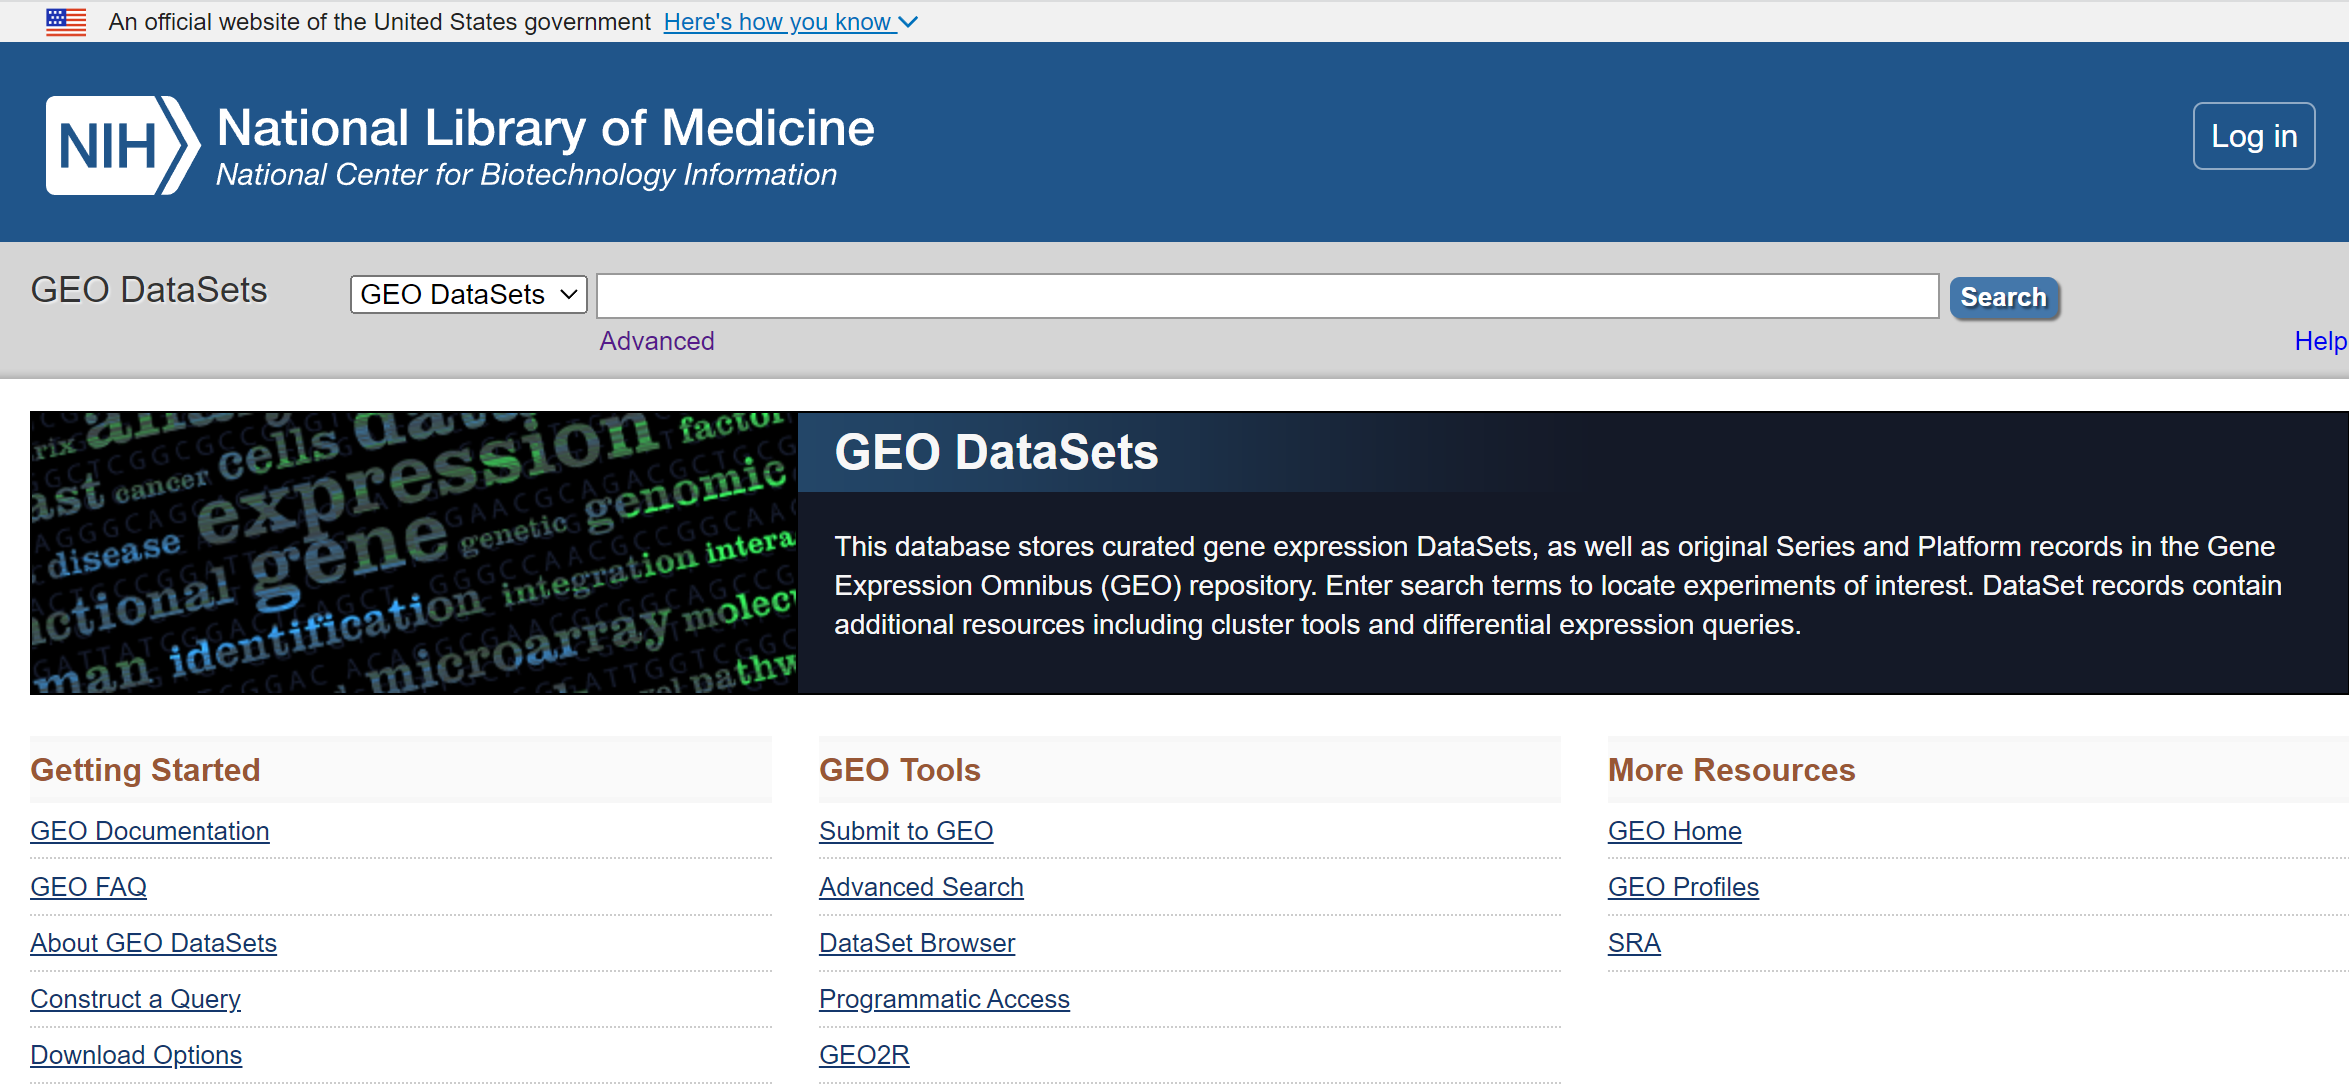


##Step 2
Retrive the gene data using the keyword trait or condition by advanced research
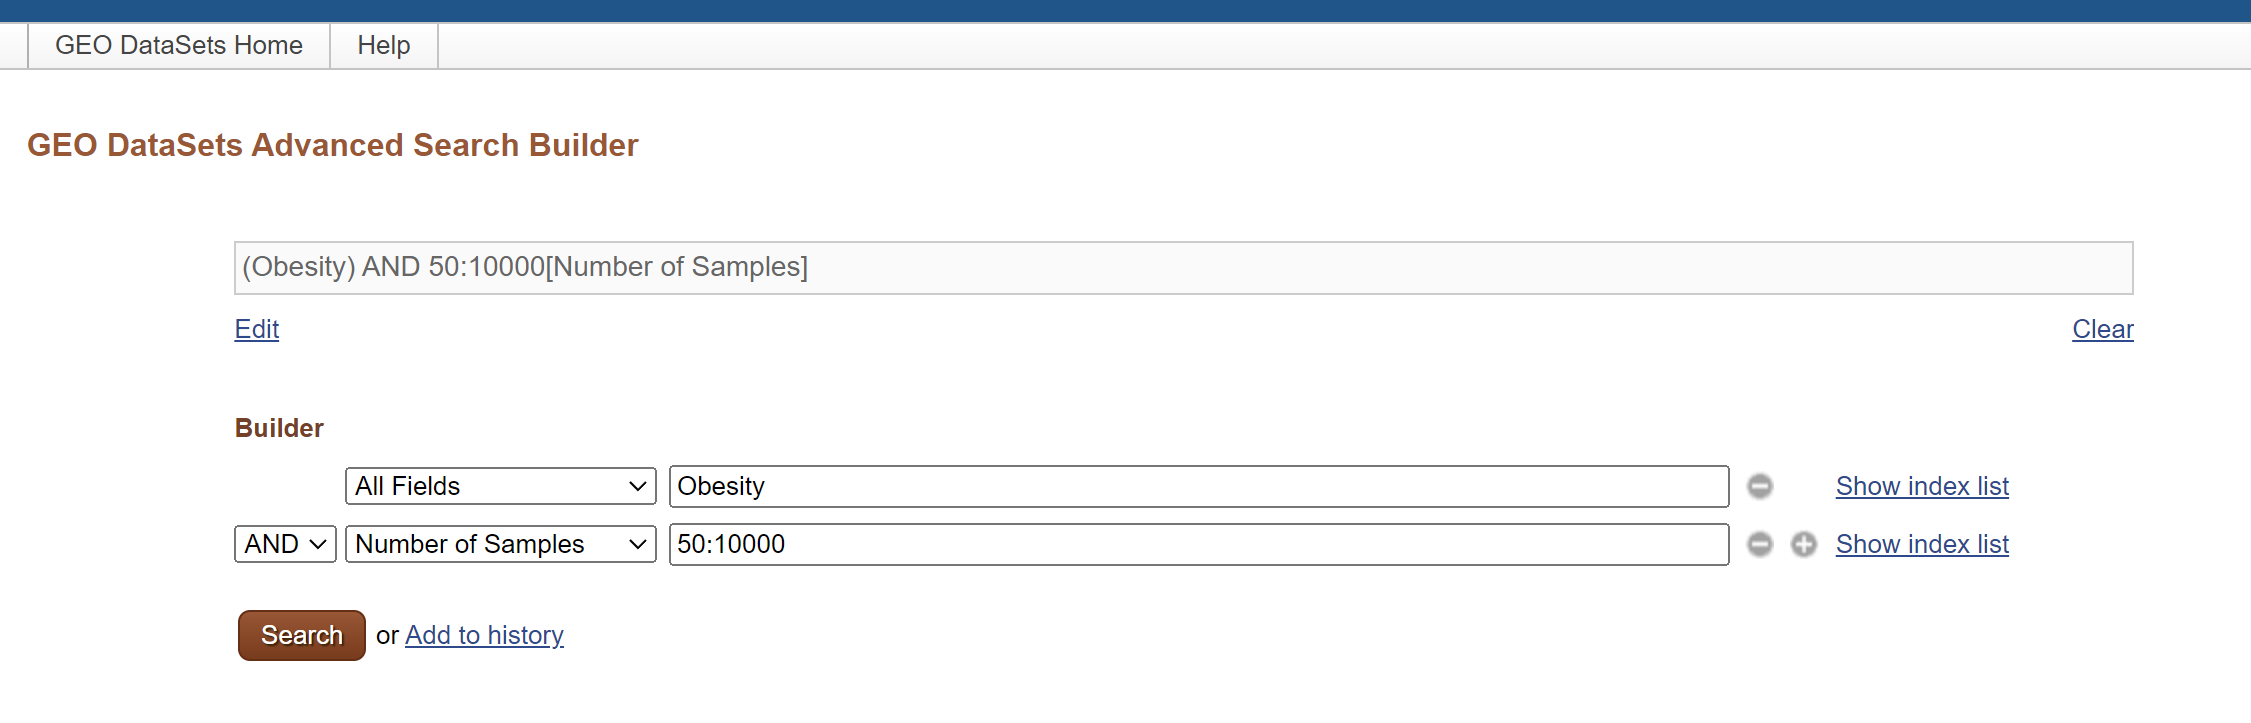

##Step 3
Select sereies with samples that possess both the trait of interest and those that do not. Note you can click on the "analyze with GEO2R" and then the clinical information will be shown for use.



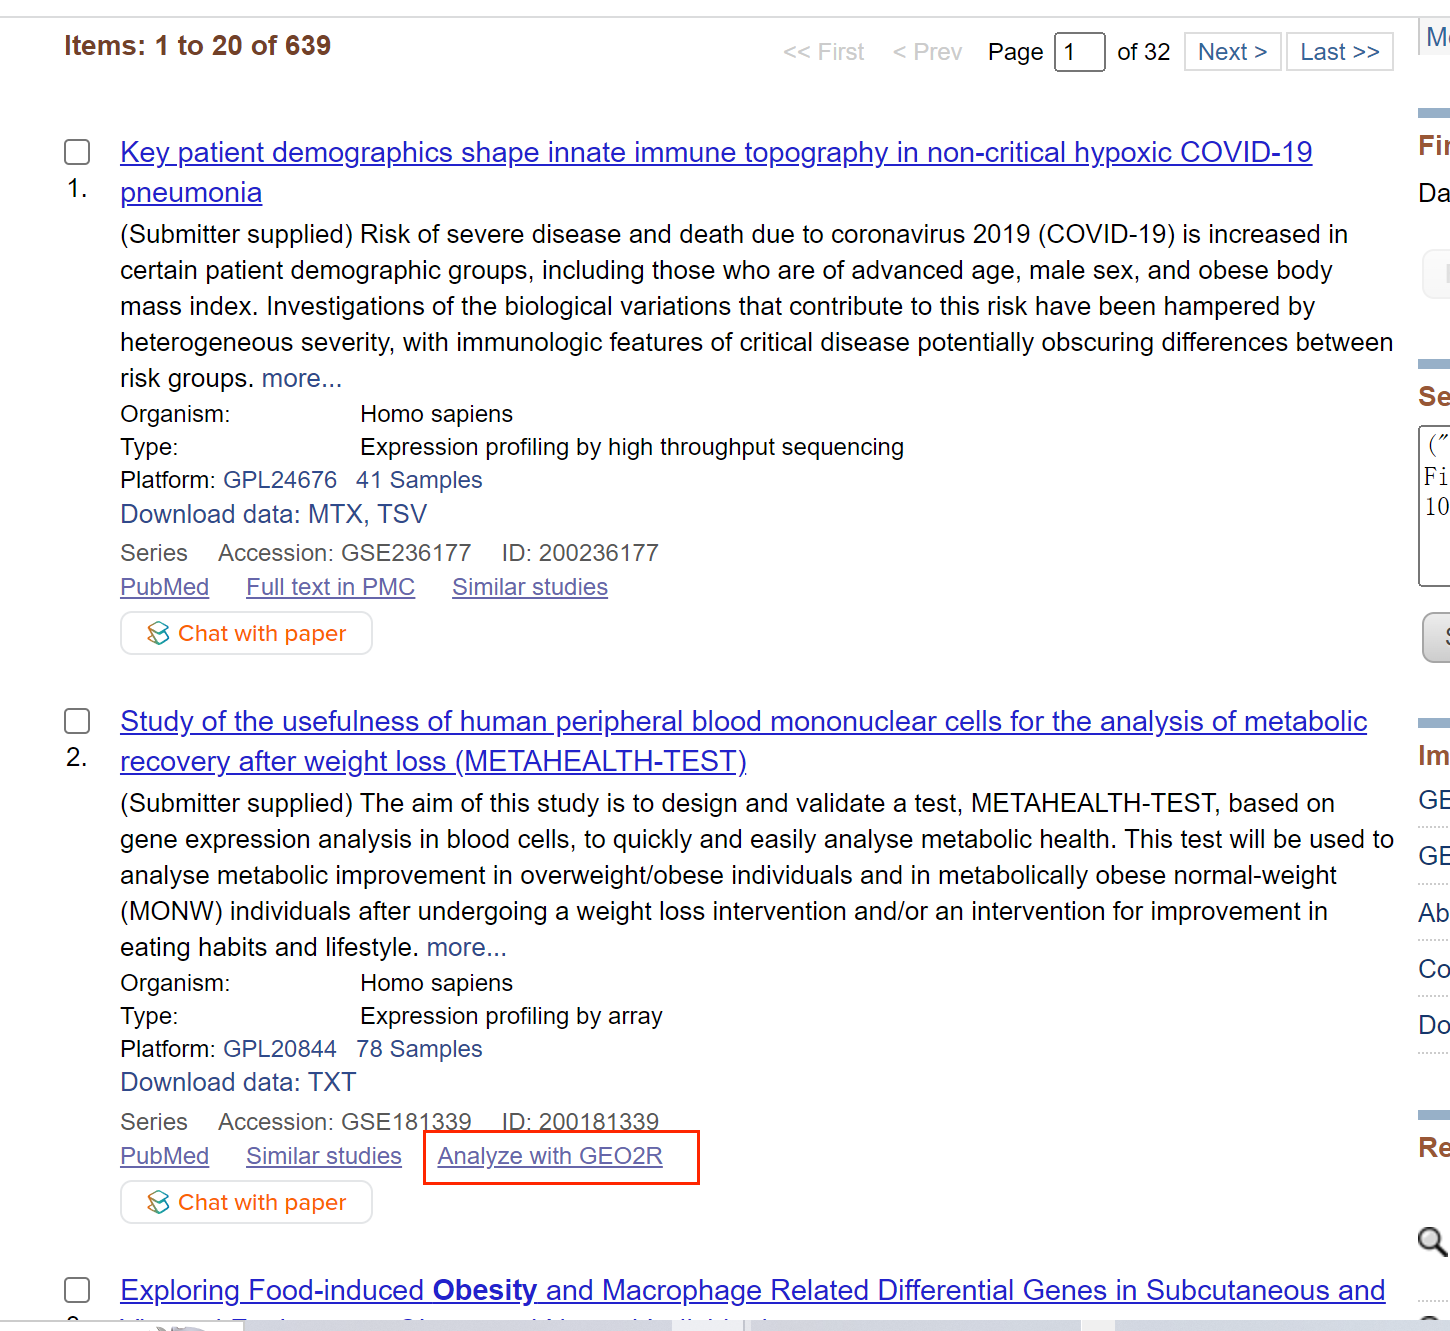


## Step 4
Download family.soft.gz
and matrix.txt.gz files. Note some of these files with
small sizes like a few KB do not contain gene expression data, and you need to find the
others.
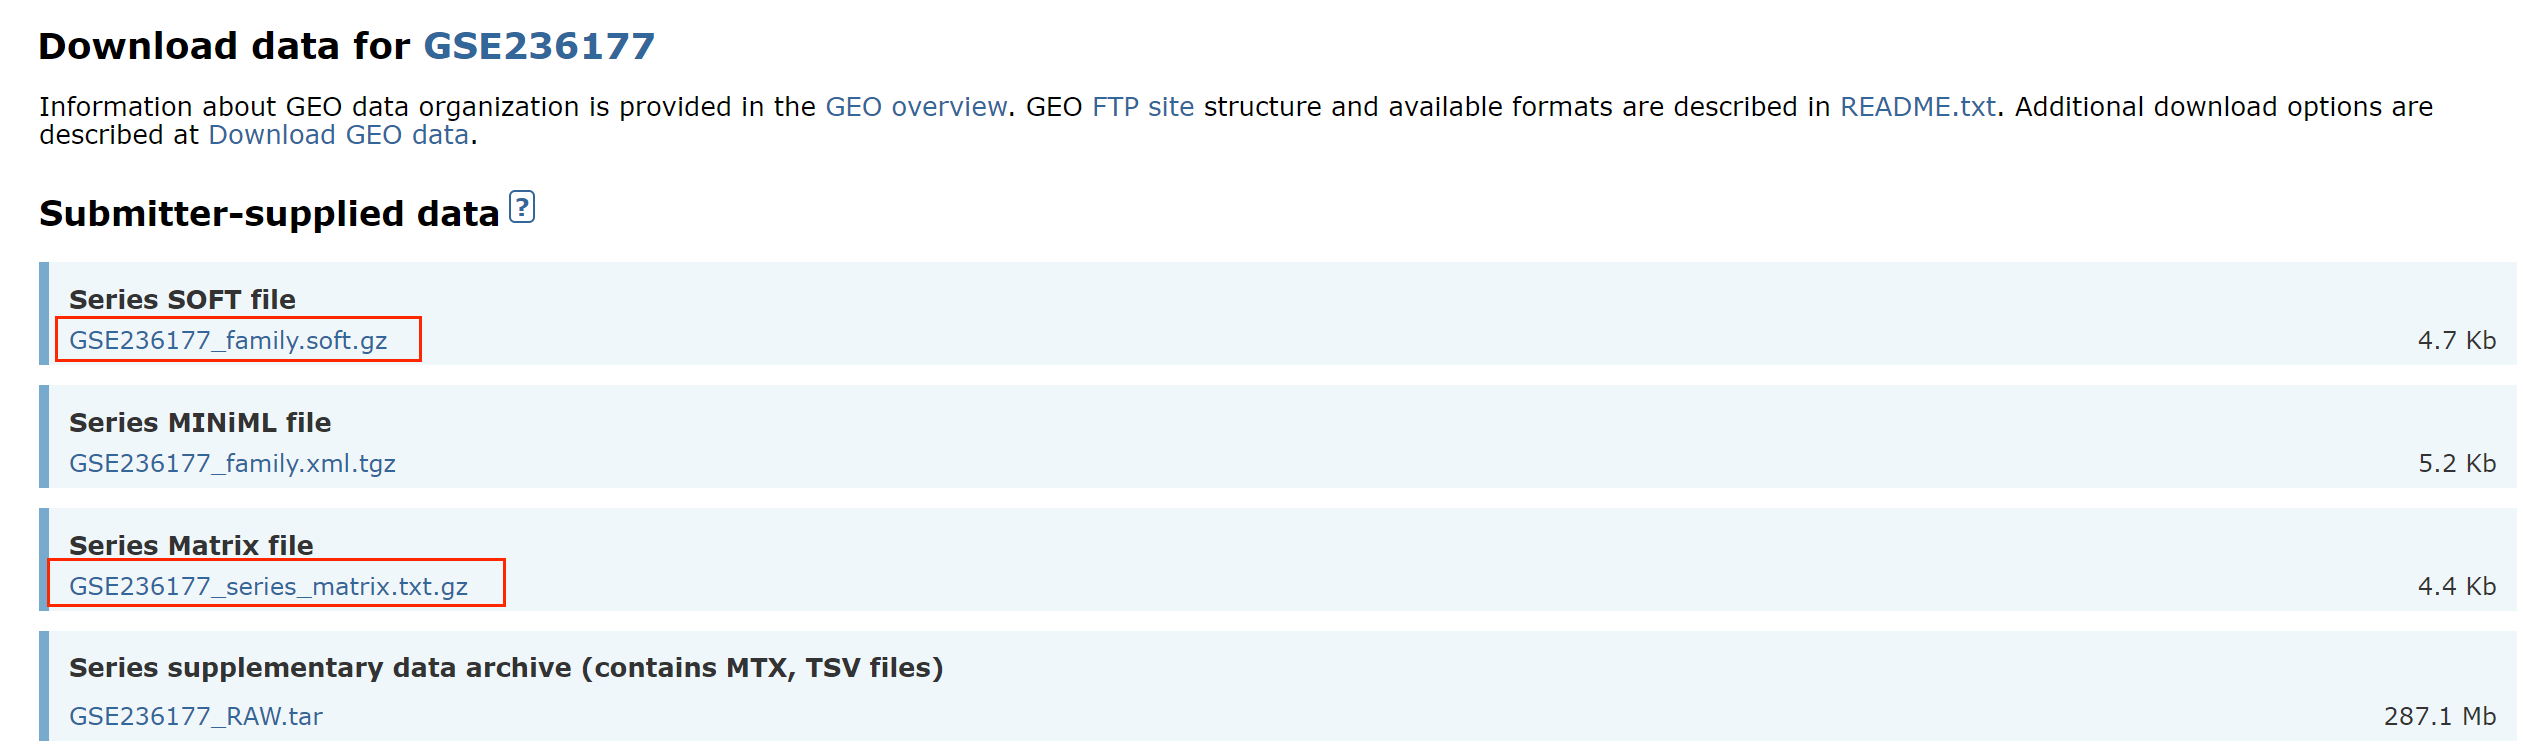

#Set Basic Info.

In [ ]:
# This cell is only for use on Google Colab. Skip it if you run your code in other environments

import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
proj_dir = '/content/drive/MyDrive/AI4Science_Public/question_generation/Datasets'
os.chdir(proj_dir)

Mounted at /content/drive


In [ ]:
# Set basic info
trait = "Epilepsy"
condition = 'Obesity'

# 1. Gene Data Preparation

In [ ]:
!pip install sparse_lmm

In [ ]:
geo_root = '/content/drive/MyDrive/AI4Science_Public/question_generation/Datasets/GEO'

##Gene Data for Condition

In [ ]:
import gzip
import pandas as pd
import os
import io

# Process the clinical data to get the mapping between gene names and gene probes.
condition_clinical_data_path = os.path.join(geo_root, '3_Gene_FTO_Trait_Obesity/GSE78958/GSE78958_family.soft.gz')

with gzip.open(condition_clinical_data_path, 'rt') as f:
    contents = f.read()
# Remove the lines that start with '^, '!', and '#' using the str.startswith() method
lines = contents.split('\n')
filtered_lines = [line for line in lines if not (line.startswith('^') or line.startswith('!') or line.startswith('#'))]
filtered_content = '\n'.join(filtered_lines)
condition_map_data = pd.read_csv(io.StringIO(filtered_content), delimiter='\t',low_memory=False)
print("Map data:")
# map_data['Gene Symbol']  # Gene names. Some of the series only provide accession of gene in GenBank (e.g., GB_ACC), you need to use GB_ACC to search for the gene name in GeneBank website.
# map_data['ID']  # Gene probes that exit both in gene data and map data
condition_map_data = condition_map_data.loc[:,['ID','Gene Symbol']]
condition_map_data = condition_map_data.dropna()
condition_map_data



Map data:


,ID,Gene Symbol
0,1007_s_at,DDR1 /// MIR4640
1,1053_at,RFC2
2,117_at,HSPA6
3,121_at,PAX8
4,1255_g_at,GUCA1A
...,...,...
22232,AFFX-HUMGAPDH/M33197_M_at,GAPDH
22233,AFFX-HUMISGF3A/M97935_3_at,STAT1
22234,AFFX-HUMISGF3A/M97935_5_at,STAT1
22235,AFFX-HUMISGF3A/M97935_MA_at,STAT1


In [ ]:
# Read gene data

condition_gene_data_path = os.path.join(geo_root, '3_Gene_FTO_Trait_Obesity/GSE78958/GSE78958_series_matrix.txt.gz')
condition_gene_data = pd.read_csv(condition_gene_data_path, compression='gzip',skiprows=52, comment='!', delimiter='\t')
print("Gene Data:")
condition_gene_data = condition_gene_data.dropna()
condition_gene_data

Gene Data:


,ID_REF,GSM2082085,GSM2082086,GSM2082087,GSM2082088,GSM2082089,GSM2082090,GSM2082091,GSM2082092,GSM2082093,...,GSM2082499,GSM2082500,GSM2082501,GSM2082502,GSM2082503,GSM2082504,GSM2082505,GSM2082506,GSM2082507,GSM2082508
0,1007_s_at,11.28850,11.03150,11.16710,10.99510,10.59830,10.66480,10.46060,10.86280,10.67120,...,11.33190,11.07390,11.03590,11.50600,10.82540,10.57120,11.13250,10.37340,10.98720,11.38370
1,1053_at,7.63904,7.26402,7.68085,6.69447,7.03229,7.67410,7.13190,7.17344,7.72702,...,7.47437,6.75757,7.39019,7.42222,7.81756,7.35957,7.13813,8.34150,8.30056,6.88597
2,117_at,8.04600,6.95939,7.66881,7.20154,7.44421,6.81892,7.69349,7.17604,7.43512,...,6.59420,6.07500,8.91532,8.47447,8.86056,7.58294,9.00407,9.44754,8.49592,7.98684
3,121_at,8.40344,8.10701,7.64901,7.61717,7.88172,7.42525,8.52529,8.85369,7.66742,...,8.12033,7.94675,8.36161,8.24828,8.09233,7.56064,7.90098,7.96661,8.30756,8.30535
4,1255_g_at,3.25795,3.23091,3.15074,3.80748,3.35172,3.32401,3.40824,3.53437,3.24152,...,3.55685,3.33472,3.96949,3.23512,3.40241,4.27268,3.10499,3.29700,3.69600,3.95314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22272,AFFX-ThrX-5_at,3.88166,3.80152,3.66039,3.35783,3.70256,3.83488,3.67033,4.05419,3.32463,...,4.13470,4.15608,4.21411,4.09967,3.87734,3.94543,3.82307,4.03133,3.99748,4.12102
22273,AFFX-ThrX-M_at,3.91730,3.47960,2.86268,2.99534,3.04051,3.56954,3.59695,3.38818,3.07477,...,3.59862,3.50953,3.78166,3.48145,3.99519,4.08996,4.10022,6.06674,3.49158,3.50046
22274,AFFX-TrpnX-3_at,3.16477,3.17312,2.99680,2.97375,3.20824,3.05029,3.05519,3.09737,2.88569,...,3.33134,3.07075,3.28115,3.29891,3.00888,2.94178,2.97901,3.08126,3.14365,3.18247
22275,AFFX-TrpnX-5_at,3.75914,3.69434,3.79928,3.88686,3.91584,3.82882,4.11923,4.05000,3.68115,...,3.90579,3.98690,4.11565,4.22331,3.89235,3.84259,3.83147,3.79138,3.98642,3.93776


In [ ]:
# Merge two datasets
condition_gene_data = pd.merge(condition_map_data.rename(columns={'ID':'ID_REF'}), condition_gene_data, on='ID_REF').drop(columns='ID_REF').set_index('Gene Symbol')
# Converts the gene names to lower case
condition_gene_data.rename(str.lower, axis='index', inplace=True)
condition_gene_data

,GSM2082085,GSM2082086,GSM2082087,GSM2082088,GSM2082089,GSM2082090,GSM2082091,GSM2082092,GSM2082093,GSM2082094,...,GSM2082499,GSM2082500,GSM2082501,GSM2082502,GSM2082503,GSM2082504,GSM2082505,GSM2082506,GSM2082507,GSM2082508
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
ddr1 /// mir4640,11.28850,11.03150,11.16710,10.99510,10.59830,10.66480,10.46060,10.86280,10.67120,10.97620,...,11.33190,11.07390,11.03590,11.50600,10.82540,10.57120,11.13250,10.37340,10.98720,11.38370
rfc2,7.63904,7.26402,7.68085,6.69447,7.03229,7.67410,7.13190,7.17344,7.72702,6.81676,...,7.47437,6.75757,7.39019,7.42222,7.81756,7.35957,7.13813,8.34150,8.30056,6.88597
hspa6,8.04600,6.95939,7.66881,7.20154,7.44421,6.81892,7.69349,7.17604,7.43512,8.23233,...,6.59420,6.07500,8.91532,8.47447,8.86056,7.58294,9.00407,9.44754,8.49592,7.98684
pax8,8.40344,8.10701,7.64901,7.61717,7.88172,7.42525,8.52529,8.85369,7.66742,8.91888,...,8.12033,7.94675,8.36161,8.24828,8.09233,7.56064,7.90098,7.96661,8.30756,8.30535
guca1a,3.25795,3.23091,3.15074,3.80748,3.35172,3.32401,3.40824,3.53437,3.24152,3.47329,...,3.55685,3.33472,3.96949,3.23512,3.40241,4.27268,3.10499,3.29700,3.69600,3.95314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gapdh,13.65790,13.14960,11.71850,12.80670,12.77510,13.00240,11.84720,12.28220,13.50270,12.96300,...,13.39520,13.01440,12.57790,13.40130,13.73630,13.80570,13.98530,14.18820,13.18030,13.33330
stat1,10.41710,12.25150,10.37870,10.56050,11.34770,11.99420,9.99272,9.95901,12.43690,9.67842,...,9.90338,9.28871,9.31771,11.09760,10.70810,10.02190,11.34610,9.85467,11.89580,9.32593
stat1,3.46671,4.04243,3.25552,3.47548,3.52812,3.92416,3.23998,3.45656,3.76377,3.46457,...,3.40408,3.30393,3.34305,3.41187,3.66566,3.25408,3.77408,3.25113,4.22393,3.34183


##Gene Data for Trait

In [ ]:
# Read map data between genes and gene probes.

trait_clinical_data_path = os.path.join(geo_root, '128_Gene_SCNA_Trait_Epilepsy/GSE229754/GSE229754_family.soft.gz')

with gzip.open(trait_clinical_data_path, 'rt') as f:
    contents = f.read()
#Remove the lines that start with '^, '!', and '#' using the str.startswith() method
lines = contents.split('\n')
filtered_lines = [line for line in lines if not (line.startswith('^') or line.startswith('!') or line.startswith('#'))]
filtered_content = '\n'.join(filtered_lines)
trait_map_data = pd.read_csv(io.StringIO(filtered_content), delimiter='\t',low_memory=False)
print("Map data:")
#map_data_trait['GENE_SYMBOL']#Gene names. Some of the series only provide accession of gene in GenBank (e.g., GB_ACC), you need to use GB_ACC to search for the gene name in GeneBank website.
#map_data_trait['ID']#Gene probes that exit both in gene data and map data
trait_map_data = trait_map_data.loc[:,['ID','GENE_SYMBOL']]
trait_map_data = trait_map_data.dropna()
trait_map_data

Map data:


,ID,GENE_SYMBOL
0,A_42_P453055,Bcam
1,A_42_P453171,Cdc42ep4
2,A_42_P453894,RGD1306682
3,A_42_P453935,Naca
4,A_42_P453959,Lrsam1
...,...,...
30358,A_64_P397764,Setdb1
30360,A_64_P398958,Dcun1d1
30362,A_64_P399184,Utrn
30365,A_64_P399235,Nmu


In [ ]:
# Read gene data
trait_gene_data_path = os.path.join(geo_root, '128_Gene_SCNA_Trait_Epilepsy/GSE229754/GSE229754_series_matrix.txt.gz')

trait_gene_data = pd.read_csv(trait_gene_data_path, compression='gzip',skiprows=52, comment='!', delimiter='\t')
print("\nGene Data:")
trait_gene_data = trait_gene_data.dropna()
trait_gene_data


Gene Data:


,ID_REF,GSM7177374,GSM7177375,GSM7177376,GSM7177377,GSM7177378,GSM7177379,GSM7177380,GSM7177381,GSM7177382,GSM7177383,GSM7177384,GSM7177385,GSM7177386,GSM7177387,GSM7177388
12,A_42_P453171,9.618717,8.433863,9.538087,9.543251,10.020039,9.719509,9.633360,9.942926,8.854783,9.871650,9.534143,9.937196,9.731444,9.777521,9.488116
13,A_42_P453894,9.891297,8.778094,10.309369,10.504767,10.127184,10.482978,10.689914,10.721436,10.318286,10.250974,10.579251,10.805895,10.943878,10.648225,10.866075
14,A_42_P453935,12.300565,11.692756,12.274402,12.164944,12.390719,12.426871,12.293867,12.501291,11.949930,12.204927,12.219418,12.532548,12.435750,12.379909,12.252109
17,A_42_P454206,6.419549,3.914837,6.681351,6.771357,6.818306,7.073187,6.651998,7.199519,6.110339,6.252654,6.760677,6.637709,6.878462,7.278894,7.259604
18,A_42_P454301,12.669386,12.223194,12.660629,12.895776,12.932032,12.815297,12.764904,12.854589,12.129087,12.508982,12.740267,12.332501,12.623375,12.839585,12.792170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30367,A_64_P397603,8.604895,6.791420,8.578824,8.916556,8.941005,8.748435,8.263013,8.718706,7.702032,8.103861,8.239041,8.726280,8.696163,8.620053,8.834110
30369,A_64_P397764,6.294718,2.991078,6.270126,6.460323,6.452069,6.866693,7.285396,7.369830,5.708269,6.671698,6.464210,6.647207,6.614118,6.826876,6.730248
30370,A_64_P398458,6.191708,3.231680,5.847335,6.137699,6.271510,6.693318,7.283456,7.404812,5.446062,6.583452,6.656914,6.480255,6.492979,6.822436,6.627117
30371,A_64_P398958,11.284572,9.839953,10.851705,11.314264,11.087103,11.315453,11.328159,11.265058,11.322431,11.285916,11.583983,11.845487,12.017881,11.664360,10.804791


In [ ]:
trait_gene_data = pd.merge(trait_map_data.rename(columns={'ID':'ID_REF'}), trait_gene_data, on='ID_REF').drop(columns='ID_REF').set_index('GENE_SYMBOL')
# Converts the gene names to lower case
trait_gene_data.rename(str.lower, axis='index', inplace=True)
trait_gene_data

,GSM7177374,GSM7177375,GSM7177376,GSM7177377,GSM7177378,GSM7177379,GSM7177380,GSM7177381,GSM7177382,GSM7177383,GSM7177384,GSM7177385,GSM7177386,GSM7177387,GSM7177388
GENE_SYMBOL,,,,,,,,,,,,,,,
cdc42ep4,9.618717,8.433863,9.538087,9.543251,10.020039,9.719509,9.633360,9.942926,8.854783,9.871650,9.534143,9.937196,9.731444,9.777521,9.488116
rgd1306682,9.891297,8.778094,10.309369,10.504767,10.127184,10.482978,10.689914,10.721436,10.318286,10.250974,10.579251,10.805895,10.943878,10.648225,10.866075
naca,12.300565,11.692756,12.274402,12.164944,12.390719,12.426871,12.293867,12.501291,11.949930,12.204927,12.219418,12.532548,12.435750,12.379909,12.252109
armc8,6.419549,3.914837,6.681351,6.771357,6.818306,7.073187,6.651998,7.199519,6.110339,6.252654,6.760677,6.637709,6.878462,7.278894,7.259604
tnpo2,12.669386,12.223194,12.660629,12.895776,12.932032,12.815297,12.764904,12.854589,12.129087,12.508982,12.740267,12.332501,12.623375,12.839585,12.792170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dcaf8,6.569852,3.985892,6.425857,6.561163,6.595550,6.915146,7.138924,7.310038,5.562462,6.771053,6.929620,6.893683,6.514781,6.881367,6.818160
prdm4,5.853281,3.941980,6.431147,6.009738,6.591733,6.181138,6.369072,6.677113,4.859847,6.465117,6.149583,6.764878,6.825585,6.813783,5.991190
zfp212,8.957126,7.321628,9.182921,9.249625,9.202847,9.296213,9.027945,9.605019,9.132074,9.082804,9.430087,9.579921,9.440371,9.314794,9.338844


##Confirmation of Data Suitability

In [ ]:
genes_in_trait_data = trait_gene_data.index.tolist()
genes_in_condition_data = condition_gene_data.index.tolist()
def find_common_genes(list1, list2):
    common_elements = []
    for element1 in list1:
        if element1 in list2:
            common_elements.append(element1)
    return common_elements

common_genes = find_common_genes(genes_in_trait_data, genes_in_condition_data)
if len(common_genes):
    print(f"Both gene data have {len(common_genes)} identical genes:", common_genes)
else:
    print("No the same genes. Please find the other gene data for condition or trait!")
    # break


Both gene data have 5632 identical genes: ['cdc42ep4', 'naca', 'armc8', 'tnpo2', 'dixdc1', 'copb1', 'atp6v1h', 'pdgfra', 'txndc15', 'supv3l1', 'herc4', 'tnfrsf21', 'bphl', 'hlx', 'psd3', 'snx3', 'obfc1', 'lig1', 'tmem43', 'cd9', 'dzip1', 'rrp7a', 'itga1', 'bag5', 'phf2', 'itih3', 'apc2', 'sfmbt1', 'mfn2', 'naa15', 'matk', 'adcy8', 'eif2ak2', 'fam32a', 'rnf138', 'polr2d', 'cln5', 'wdr37', 'cdk5rap1', 'anapc2', 'c7', 'rnf34', 'acot13', 'ptpn6', 'unc50', 'kif16b', 'eif4e2', 'pdk2', 'trappc8', 'lsm2', 'supt6h', 'elac1', 'klf5', 'nol8', 'ptdss1', 'fhl1', 'wars', 'xylb', 'slc22a17', 'stard13', 'tfb2m', 'fam76a', 'dffa', 'srp14', 'golga2', 'mrpl24', 'med15', 'pdzrn3', 'gucy1a3', 'atp5b', 'mthfd1', 'dstyk', 'vps11', 'ap4s1', 'taf2', 'ctgf', 'nrl', 'map2k5', 'ncoa1', 'rph3al', 'b4galt3', 'rnf219', 'slc25a44', 'cox7b', 'polm', 'zc3h7a', 'tmem19', 'gnat1', 'pllp', 'pex16', 'tbcd', 'fibp', 'psme4', 'nckipsd', 'triap1', 'myc', 'ctbs', 'dok1', 'ctnna2', 'usp48', 'armc9', 'slc17a5', 'ano1', 'bcl7c', 

In [ ]:
# Find the genes related to the trait according to biomedical knowledge from OMIM

corresponding_gene_symbol_path = os.path.join(os.path.dirname(geo_root), 'Summary_Corresponding_Gene_Symbol.csv')
corresponding_gene = pd.read_csv(corresponding_gene_symbol_path)
corresponding_gene = corresponding_gene.loc[:,['Disease Name','Corresponding_Gene_Symbol']].set_index('Disease Name')
# Convert to lower case
corresponding_gene = corresponding_gene.apply(lambda x: x.astype(str).str.lower())
corresponding_gene.index = corresponding_gene.index.str.lower()
corresponding_gene

,Corresponding_Gene_Symbol
Disease Name,
breast cancer,"brca2, cdh1, ppm1d, pik3ca, kras, akt1, tp53, ..."
cystic fibrosis,"cftr, fcgr2a, tgfb1, kif21a, cdc73, crb2, rnaset2"
obesity,"lep, pparg, pomc, mc4r, enpp1, adcy3"
sickle cell anemia,"hbb, trnt1, gata1, fancb, fanca, fancf, fancc,..."
huntington's disease,"prnp, jph3, htt, gba1, mpz, psen1, apoe, gdap1..."
...,...
metabolic rate,"adrb1, mmp1, rnf212, dyrk1b, cela2a, slc25a42,..."
von willebrand disease,"vwf, gp1ba, vwa5a, vwa7, vwce, vwc2, svep1, vw..."
werner syndrome,"wrn, wrnip1, fgfr2, fbn1, mecp2, flna, tp63, t..."


### The Feasibility  of The First Stage Regression Analysis

In [ ]:
corresponding_gene_for_trait = corresponding_gene.loc[trait.lower()].tolist()[0].lower().strip().split(',')
corresponding_gene_for_trait = [gn.strip() for gn in corresponding_gene_for_trait]
print("Corresponding genes for trait", corresponding_gene_for_trait)
corresponding_gene_for_condition = corresponding_gene.loc[condition.lower()].tolist()[0].lower().strip().split(',')
corresponding_gene_for_condition = [gn.strip() for gn in corresponding_gene_for_condition]
print("Corresponding genes for condition", corresponding_gene_for_condition)

gene_regressors_for_condition = find_common_genes(corresponding_gene_for_condition, common_genes)
if len(gene_regressors_for_condition):
    print(f"The regressors of the first stage regression analysis exit both in gene data of trait and gene data of condition. \n There are(is) {len(gene_regressors_for_condition)} regressors:", gene_regressors_for_condition)
else:
    print("No the same gene regressors. Please find the other gene data for condition or trait!")
    # break


Corresponding genes for trait ['gabra1', 'gabrd', 'clcn2', 'tbc1d24', 'gabrg2', 'gabrb3', 'kcnma1', 'scn1b']
Corresponding genes for condition ['lep', 'pparg', 'pomc', 'mc4r', 'enpp1', 'adcy3']
The regressors of the first stage regression analysis exit both in gene data of trait and gene data of condition. 
 There are(is) 2 regressors: ['pomc', 'adcy3']


#Clinical Data Preparation

##Description

##Thrust 1: Acertain if the GEO sereies is suitable for the regression analysis
To determine if the GEO series is suitable for regression analysis, you need to assess whether it provides samples that include both the trait being analyzed and samples without the trait. If the series contains such samples, it can be used for regression analysis. However, if the series does not include both types of samples, alternative GEO series will need to be identified.

#Thrust 2: Understand the text information and  label the samples
To label the samples, it is important to thoroughly understand the details provided in the text. They offer information into the nature of the study, the overall design, and the characteristics of the samples, which help determine which samples possess the trait of interest (positive samples) and which do not (negative samples).

In this demo, the samples in the control group are removed, the samples without seizure (negative samples) are marked as 0, and the samples with seizure (positive samples) are marked as 1.

Note: The control group refers to a group of individuals or subjects in a scientific study or experiment that does not receive the experimental treatment or intervention.   Therefore, the trait of the samples in the control group remains unclear, we thus remove them.

##Clinical Data for Trait

In [ ]:
#Read clinical information to get the trait. Note that clear undersanding on these information is necessary.
def extract_lines_with_prefix(file_path, prefixes):
    filtered_lines = []
    with gzip.open(file_path, 'rt') as f:
      contents = f.read()
    lines = contents.split('\n')
    for line in lines:
      line = line.strip()
      for prefix in prefixes:
        if line.startswith(prefix):
          filtered_lines.append(line)
          break
    return filtered_lines
trait_file_path = trait_gene_data_path # gene_data_path_trait
trait_prefixes = ['!Sample_geo_accession','!Series_title', '!Series_summary', '!Series_overall_design', '!Sample_characteristics_ch1']
trait_filtered_lines = extract_lines_with_prefix(trait_file_path, trait_prefixes)
trait_filtered_content = '\n'.join(trait_filtered_lines)
print(trait_filtered_content + "\n")

!Series_title	"Transcriptomic analysis reveals distinct adaptive molecular mechanism in the hippocampal CA3 from rats susceptible or not-susceptible to hyperthermia-induced seizures"
!Series_summary	"This study aimed to identify the genomic differences - through differential gene expression, miRNAs, and WGCNA transcriptional modules among animals with or without seizure after insult and non-insulted controls."
!Series_overall_design	"Use of a rat (Rattus norvegicus) model of hyperthermia-induced seizure to characterize the genomic mechanism underlying febrile seizures in epilepsy. The aim of the study is to identify the genomic differences in hippocampal ventral CA3 region - through differential gene expression, miRNAs, and WGCNA transcriptional modules among animals with (HS) or without (HNS) seizure after insult and non-insulted controls (CT). Here, samples from the animal of all groups in the P30 time-interval."
!Sample_geo_accession	"GSM7177374"	"GSM7177375"	"GSM7177376"	"GSM717737

###Automatic Labeling
You can use ChatGPT to help understand the text information and label the samples.

##Prompt for understanding text

Analyze if the text {filtered_content} including samples with charateristic related to the trait {trait} or not.
The output should only be yes or no.

##Code (I recommend going directly to the GPT website)
ascertain_prompt  = (f"Analyze if the text {filtered_content} including samples with charateristic related to the trait {trait} or not. "
f"The output should only be yes or no")

response = openai.Completion.create(engine=deployment_name, prompt=ascertain_prompt, max_tokens=20)

text = response['choices'][0]['text']

print(text)

##Prompt for labeling

According to {filtered_content}, please create a table using Panda where the row name represents the trait {trait} and the column names represent the GEO accessions of the samples. Then fill in value 0 for the samples without the trait {trait} and  value 1 to the samples with the trait {trait}. The output should only be a table that can be used by python

##Code (I recommend going directly to the GPT website)

Label_prompt = (f"According to {filtered_content}, please create a table using Panda where the row name represents the trait {trait} and the column names represent the  GEO accessions of the samples. "
f" Then fill in value 0 for the samples without the trait {trait} and the value 1 to the samples with the trait {trait}"
f"The output should only be a table that can be used by python")

response = openai.Completion.create(engine=deployment_name, prompt=Label_prompt, max_tokens=500)

text = response['choices'][0]['text']

print(text)

###Manual Labeling

In [ ]:
#This is an example of manual labeling
trait_prefix = ['!Sample_geo_accession', '!Sample_characteristics_ch1']
trait_filtered_lines = extract_lines_with_prefix(trait_file_path, trait_prefix)
trait_filtered_content = '\n'.join(trait_filtered_lines)
trait_clinical_data = pd.read_csv(io.StringIO(trait_filtered_content), delimiter='\t',low_memory=False)
print("Clinical Data:")
trait_clinical_data

Clinical Data:


,!Sample_geo_accession,GSM7177374,GSM7177375,GSM7177376,GSM7177377,GSM7177378,GSM7177379,GSM7177380,GSM7177381,GSM7177382,GSM7177383,GSM7177384,GSM7177385,GSM7177386,GSM7177387,GSM7177388
0,!Sample_characteristics_ch1,gender: Male,gender: Male,gender: Male,gender: Male,gender: Male,gender: Male,gender: Male,gender: Male,gender: Male,gender: Male,gender: Male,gender: Male,gender: Male,gender: Male,gender: Male
1,!Sample_characteristics_ch1,age (days): 30,age (days): 30,age (days): 30,age (days): 30,age (days): 30,age (days): 30,age (days): 30,age (days): 30,age (days): 30,age (days): 30,age (days): 30,age (days): 30,age (days): 30,age (days): 30,age (days): 30
2,!Sample_characteristics_ch1,group: animal without seizure,group: animal without seizure,group: animal without seizure,group: animal without seizure,group: animal without seizure,group: animal with seizure,group: animal with seizure,group: animal with seizure,group: animal with seizure,group: animal with seizure,group: Control,group: Control,group: Control,group: Control,group: Control


In [ ]:
trait_clinical_data = trait_clinical_data.drop(trait_clinical_data.index[[0, 1]])  # Remove the unrelated first and second rows
trait_clinical_data = trait_clinical_data.drop(columns=[trait_clinical_data.columns[0]])  # Remove the unrelated first column
trait_clinical_data.index = [trait]
trait_clinical_data


,GSM7177374,GSM7177375,GSM7177376,GSM7177377,GSM7177378,GSM7177379,GSM7177380,GSM7177381,GSM7177382,GSM7177383,GSM7177384,GSM7177385,GSM7177386,GSM7177387,GSM7177388
Epilepsy,group: animal without seizure,group: animal without seizure,group: animal without seizure,group: animal without seizure,group: animal without seizure,group: animal with seizure,group: animal with seizure,group: animal with seizure,group: animal with seizure,group: animal with seizure,group: Control,group: Control,group: Control,group: Control,group: Control


In [ ]:
# Label the samples and remove the control group in clinical data
trait_clinical_data = trait_clinical_data.replace("group: animal without seizure", 0)
trait_clinical_data = trait_clinical_data.replace("group: animal with seizure", 1)
control_group_samples_id = trait_clinical_data.columns[trait_clinical_data.eq('group: Control').any()]
trait_clinical_data = trait_clinical_data.drop(columns=control_group_samples_id)
trait_clinical_data

,GSM7177374,GSM7177375,GSM7177376,GSM7177377,GSM7177378,GSM7177379,GSM7177380,GSM7177381,GSM7177382,GSM7177383
Epilepsy,0,0,0,0,0,1,1,1,1,1


In [ ]:
#Remove the control group in gene data
trait_gene_data = trait_gene_data.drop(columns=control_group_samples_id)
trait_gene_data

,GSM7177374,GSM7177375,GSM7177376,GSM7177377,GSM7177378,GSM7177379,GSM7177380,GSM7177381,GSM7177382,GSM7177383
GENE_SYMBOL,,,,,,,,,,
cdc42ep4,9.618717,8.433863,9.538087,9.543251,10.020039,9.719509,9.633360,9.942926,8.854783,9.871650
rgd1306682,9.891297,8.778094,10.309369,10.504767,10.127184,10.482978,10.689914,10.721436,10.318286,10.250974
naca,12.300565,11.692756,12.274402,12.164944,12.390719,12.426871,12.293867,12.501291,11.949930,12.204927
armc8,6.419549,3.914837,6.681351,6.771357,6.818306,7.073187,6.651998,7.199519,6.110339,6.252654
tnpo2,12.669386,12.223194,12.660629,12.895776,12.932032,12.815297,12.764904,12.854589,12.129087,12.508982
...,...,...,...,...,...,...,...,...,...,...
dcaf8,6.569852,3.985892,6.425857,6.561163,6.595550,6.915146,7.138924,7.310038,5.562462,6.771053
prdm4,5.853281,3.941980,6.431147,6.009738,6.591733,6.181138,6.369072,6.677113,4.859847,6.465117
zfp212,8.957126,7.321628,9.182921,9.249625,9.202847,9.296213,9.027945,9.605019,9.132074,9.082804


In [ ]:
#Merge two datasets
trait_merged_data = pd.concat([trait_gene_data, trait_clinical_data]).T
# merged_data_trait
# Check whether column names are duplicated
duplicated_columns = trait_merged_data.columns[trait_merged_data.columns.duplicated()]
print("Duplicate column names:", duplicated_columns)
# Delete duplicate column names and save only one of the columns
trait_merged_data = trait_merged_data.loc[:, ~trait_merged_data.columns.duplicated()]
trait_merged_data

Duplicate column names: Index(['suv420h1', 'pppde1', 'enc1', 'rgd1311066', 'usp48', 'sdc2', 'polr2f',
       'pole3', 'riok3', 'atcay',
       ...
       'csf1r', 'btf3', 'arnt2', 'nrip1', 'crip2', 'rpl35', 'ankrd13c',
       'brwd3', 'hrh3', 'dcun1d1'],
      dtype='object', length=875)


,cdc42ep4,rgd1306682,naca,armc8,tnpo2,dixdc1,copb1,atp6v1h,mtfmt,pdgfra,...,csn1s1,sesn1,srsf7,loc362795,med8,dcaf8,prdm4,zfp212,setdb1,Epilepsy
GSM7177374,9.618717,9.891297,12.300565,6.419549,12.669386,10.059711,9.799312,11.537340,9.030334,9.984090,...,6.914544,7.092060,11.189447,5.304775,8.510160,6.569852,5.853281,8.957126,6.294718,0.0
GSM7177375,8.433863,8.778094,11.692756,3.914837,12.223194,8.888625,8.817946,11.016124,7.773567,8.685311,...,4.811550,5.153667,10.612376,2.772142,6.968354,3.985892,3.941980,7.321628,2.991078,0.0
GSM7177376,9.538087,10.309369,12.274402,6.681351,12.660629,10.065700,9.892569,11.592283,9.041031,9.865159,...,7.110058,6.917058,10.932825,6.182122,8.679627,6.425857,6.431147,9.182921,6.270126,0.0
GSM7177377,9.543251,10.504767,12.164944,6.771357,12.895776,10.251254,9.950316,11.608143,9.053718,9.907992,...,7.464339,7.051771,11.286278,6.126542,8.943465,6.561163,6.009738,9.249625,6.460323,0.0
GSM7177378,10.020039,10.127184,12.390719,6.818306,12.932032,10.083568,9.931398,11.364371,9.258897,10.174566,...,7.488847,7.192097,11.084257,6.668186,8.934796,6.595550,6.591733,9.202847,6.452069,0.0
GSM7177379,9.719509,10.482978,12.426871,7.073187,12.815297,10.298792,10.162561,11.634647,9.370527,10.210643,...,5.281077,7.654190,11.083828,7.071562,8.878292,6.915146,6.181138,9.296213,6.866693,1.0
GSM7177380,9.633360,10.689914,12.293867,6.651998,12.764904,10.318104,10.166268,11.912020,9.188787,10.154711,...,5.672141,8.104233,11.007412,6.471502,8.796462,7.138924,6.369072,9.027945,7.285396,1.0
GSM7177381,9.942926,10.721436,12.501291,7.199519,12.854589,10.656119,10.371856,12.017256,9.531203,10.335655,...,6.177870,8.090580,11.068743,6.792501,9.294503,7.310038,6.677113,9.605019,7.369830,1.0
GSM7177382,8.854783,10.318286,11.949930,6.110339,12.129087,9.847022,9.480552,11.130028,8.646181,9.599423,...,4.943605,6.081780,10.529133,5.636592,8.190744,5.562462,4.859847,9.132074,5.708269,1.0
GSM7177383,9.871650,10.250974,12.204927,6.252654,12.508982,10.285210,9.728507,11.226546,8.909253,9.998819,...,6.415080,7.176658,10.570252,5.500868,8.500556,6.771053,6.465117,9.082804,6.671698,1.0


##Clinical Data for Condition

###Manual Labeling

In [ ]:
#Read clinical information. Note that clear undersanding on these information is necessary.
condition_file_path = condition_gene_data_path
prefixes_condition = ['!Sample_geo_accession','!Series_title', '!Series_summary', '!Series_overall_design', '!Sample_characteristics_ch1']
condition_filtered_lines = extract_lines_with_prefix(condition_file_path, prefixes_condition)
condition_filtered_content = '\n'.join(condition_filtered_lines)
#In this data, the label information come from "!Series_summary = Methods: Affymetrix U133 2.0 gene expression data were generated for 405 primary breast tumors using RNA isolated from laser microdissected tissues.  Patients were classified as normal-weight (BMI<25), overweight (BMI 25-29.9) or obese (BMI>30). Statistical analysis was performed by ANOVA using Partek Genomics Suite version 6.6 using a false discovery rate <0.05 to define significance.
print(condition_filtered_content + "\n")

!Series_title	"Effect of obesity on molecular characteristics of invasive breast tumors: gene expression analysis of 405 tumors by BMI"
!Series_summary	"Background: Obesity is a risk factor for breast cancer in postmenopausal women and is associated with decreased survival and less favorable clinical characteristics such as greater tumor burden, higher grade, and poor prognosis, regardless of menopausal status. Despite the negative impact of obesity on clinical outcome, molecular mechanisms through which excess adiposity influences breast cancer etiology are not well-defined."
!Series_summary	""
!Series_summary	"Methods: Affymetrix U133 2.0 gene expression data were generated for 405 primary breast tumors using RNA isolated from laser microdissected tissues.  Patients were classified as normal-weight (BMI<25), overweight (BMI 25-29.9) or obese (BMI>30). Statistical analysis was performed by ANOVA using Partek Genomics Suite version 6.6 using a false discovery rate <0.05 to define signi

In [ ]:
#This is an example of manual labeling
condition_prefixes = ['!Sample_geo_accession', '!Sample_characteristics_ch1']
condition_filtered_lines = extract_lines_with_prefix(condition_file_path, condition_prefixes)
condition_filtered_content = '\n'.join(condition_filtered_lines)
condition_clinical_data = pd.read_csv(io.StringIO(condition_filtered_content), delimiter='\t',low_memory=False)
print("Clinical Data:")
condition_clinical_data

Clinical Data:


,!Sample_geo_accession,GSM2082085,GSM2082086,GSM2082087,GSM2082088,GSM2082089,GSM2082090,GSM2082091,GSM2082092,GSM2082093,...,GSM2082499,GSM2082500,GSM2082501,GSM2082502,GSM2082503,GSM2082504,GSM2082505,GSM2082506,GSM2082507,GSM2082508
0,!Sample_characteristics_ch1,patient ethnicity: European American,patient ethnicity: African American,patient ethnicity: European American,patient ethnicity: European American,patient ethnicity: European American,patient ethnicity: European American,patient ethnicity: European American,patient ethnicity: European American,patient ethnicity: European American,...,patient ethnicity: European American,patient ethnicity: European American,patient ethnicity: European American,patient ethnicity: European American,patient ethnicity: European American,patient ethnicity: European American,patient ethnicity: European American,patient ethnicity: European American,patient ethnicity: Asian,patient ethnicity: European American
1,!Sample_characteristics_ch1,bmi: 25-29.99,bmi: 30+,bmi: Unk,bmi: 25-29.99,bmi: Unk,bmi: Unk,bmi: <25,bmi: <25,bmi: <25,...,bmi: 25-29.99,bmi: <25,bmi: 25-29.99,bmi: 25-29.99,bmi: 30+,bmi: 25-29.99,bmi: 30+,bmi: 30+,bmi: 30+,bmi: 25-29.99
2,!Sample_characteristics_ch1,tumor grade: Moderately differentiated (grade 2),tumor grade: Poorly differentiated (grade 3),tumor grade: Moderately differentiated (grade 2),tumor grade: Moderately differentiated (grade 2),tumor grade: Moderately differentiated (grade 2),tumor grade: Poorly differentiated (grade 3),tumor grade: Well-differentiated (grade 1),tumor grade: Moderately differentiated (grade 2),tumor grade: Poorly differentiated (grade 3),...,tumor grade: Moderately differentiated (grade 2),tumor grade: Moderately differentiated (grade 2),tumor grade: Moderately differentiated (grade 2),tumor grade: Moderately differentiated (grade 2),tumor grade: Poorly differentiated (grade 3),tumor grade: Well-differentiated (grade 1),tumor grade: Moderately differentiated (grade 2),tumor grade: Poorly differentiated (grade 3),tumor grade: Poorly differentiated (grade 3),tumor grade: Well-differentiated (grade 1)
3,!Sample_characteristics_ch1,tumor subtype (via breastprs): Basal Like,tumor subtype (via breastprs): Luminal B,tumor subtype (via breastprs): Luminal A,tumor subtype (via breastprs): Luminal A,tumor subtype (via breastprs): Luminal A,tumor subtype (via breastprs): Basal Like,tumor subtype (via breastprs): Luminal A,tumor subtype (via breastprs): Luminal A,tumor subtype (via breastprs): Basal Like,...,tumor subtype (via breastprs): Luminal A,tumor subtype (via breastprs): Luminal A,tumor subtype (via breastprs): HER2 enriched,tumor subtype (via breastprs): Luminal A,tumor subtype (via breastprs): Luminal A,tumor subtype (via breastprs): Luminal A,tumor subtype (via breastprs): Luminal A,tumor subtype (via breastprs): Luminal B,tumor subtype (via breastprs): Luminal B,tumor subtype (via breastprs): HER2 enriched
4,!Sample_characteristics_ch1,tumor stage: Stage IV,tumor stage: Stage I,tumor stage: Stage I,tumor stage: Stage I,tumor stage: Stage I,tumor stage: Stage I,tumor stage: Stage I,tumor stage: Stage I,tumor stage: Stage IIB,...,tumor stage: Stage IIIA,tumor stage: Stage IIB,tumor stage: Stage IIB,tumor stage: Stage I,tumor stage: Stage IIA,tumor stage: Stage IIA,tumor stage: Stage IIB,tumor stage: Stage IIA,tumor stage: Stage IIB,tumor stage: Stage IIA


In [ ]:
condition_clinical_data = condition_clinical_data.drop(condition_clinical_data.index[[0,2,3,4]])  # Remove the unrelated first and second rows
condition_clinical_data = condition_clinical_data.drop(columns=[condition_clinical_data.columns[0]])  # Remove the unrelated first column
condition_clinical_data.index = [condition]
#In this data, the label information come from "!Series_summary = Methods: Affymetrix U133 2.0 gene expression data were generated for 405 primary breast tumors using RNA isolated from laser microdissected tissues.
#Patients were classified as normal-weight (BMI<25), overweight (BMI 25-29.9) or obese (BMI>30). Statistical analysis was performed by ANOVA using Partek Genomics Suite version 6.6 using a false discovery rate <0.05 to define significance.
condition_clinical_data

,GSM2082085,GSM2082086,GSM2082087,GSM2082088,GSM2082089,GSM2082090,GSM2082091,GSM2082092,GSM2082093,GSM2082094,...,GSM2082499,GSM2082500,GSM2082501,GSM2082502,GSM2082503,GSM2082504,GSM2082505,GSM2082506,GSM2082507,GSM2082508
Obesity,bmi: 25-29.99,bmi: 30+,bmi: Unk,bmi: 25-29.99,bmi: Unk,bmi: Unk,bmi: <25,bmi: <25,bmi: <25,bmi: <25,...,bmi: 25-29.99,bmi: <25,bmi: 25-29.99,bmi: 25-29.99,bmi: 30+,bmi: 25-29.99,bmi: 30+,bmi: 30+,bmi: 30+,bmi: 25-29.99


In [ ]:
condition_clinical_data = condition_clinical_data.replace("bmi: 25-29.99", 1)
condition_clinical_data = condition_clinical_data.replace("bmi: 30+", 1)
condition_clinical_data = condition_clinical_data.replace("bmi: <25", 0)
condition_clinical_data = condition_clinical_data.replace("bmi: Unk", "NaN")
condition_clinical_data


,GSM2082085,GSM2082086,GSM2082087,GSM2082088,GSM2082089,GSM2082090,GSM2082091,GSM2082092,GSM2082093,GSM2082094,...,GSM2082499,GSM2082500,GSM2082501,GSM2082502,GSM2082503,GSM2082504,GSM2082505,GSM2082506,GSM2082507,GSM2082508
Obesity,1,1,NaN,1,NaN,NaN,0,0,0,0,...,1,0,1,1,1,1,1,1,1,1


In [ ]:
NaN_Samples_id = condition_clinical_data.columns[condition_clinical_data.eq('NaN').any()]
print(NaN_Samples_id)
condition_clinical_data = condition_clinical_data.drop(columns=NaN_Samples_id)
condition_clinical_data

Index(['GSM2082087', 'GSM2082089', 'GSM2082090', 'GSM2082103', 'GSM2082105',
       'GSM2082107', 'GSM2082108', 'GSM2082111', 'GSM2082154', 'GSM2082319',
       'GSM2082322', 'GSM2082326', 'GSM2082366', 'GSM2082389', 'GSM2082391',
       'GSM2082411', 'GSM2082417', 'GSM2082456', 'GSM2082479', 'GSM2082482'],
      dtype='object')


,GSM2082085,GSM2082086,GSM2082088,GSM2082091,GSM2082092,GSM2082093,GSM2082094,GSM2082095,GSM2082096,GSM2082097,...,GSM2082499,GSM2082500,GSM2082501,GSM2082502,GSM2082503,GSM2082504,GSM2082505,GSM2082506,GSM2082507,GSM2082508
Obesity,1,1,1,0,0,0,0,0,0,1,...,1,0,1,1,1,1,1,1,1,1


In [ ]:
#Remove the samples with NaN in gene data
condition_gene_data = condition_gene_data.drop(columns=NaN_Samples_id)
condition_gene_data

,GSM2082085,GSM2082086,GSM2082088,GSM2082091,GSM2082092,GSM2082093,GSM2082094,GSM2082095,GSM2082096,GSM2082097,...,GSM2082499,GSM2082500,GSM2082501,GSM2082502,GSM2082503,GSM2082504,GSM2082505,GSM2082506,GSM2082507,GSM2082508
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
ddr1 /// mir4640,11.28850,11.03150,10.99510,10.46060,10.86280,10.67120,10.97620,10.42580,11.17150,11.27190,...,11.33190,11.07390,11.03590,11.50600,10.82540,10.57120,11.13250,10.37340,10.98720,11.38370
rfc2,7.63904,7.26402,6.69447,7.13190,7.17344,7.72702,6.81676,7.62211,7.03182,7.28498,...,7.47437,6.75757,7.39019,7.42222,7.81756,7.35957,7.13813,8.34150,8.30056,6.88597
hspa6,8.04600,6.95939,7.20154,7.69349,7.17604,7.43512,8.23233,8.35312,7.74082,10.99640,...,6.59420,6.07500,8.91532,8.47447,8.86056,7.58294,9.00407,9.44754,8.49592,7.98684
pax8,8.40344,8.10701,7.61717,8.52529,8.85369,7.66742,8.91888,7.90676,8.09221,8.87781,...,8.12033,7.94675,8.36161,8.24828,8.09233,7.56064,7.90098,7.96661,8.30756,8.30535
guca1a,3.25795,3.23091,3.80748,3.40824,3.53437,3.24152,3.47329,3.12373,3.35496,4.06378,...,3.55685,3.33472,3.96949,3.23512,3.40241,4.27268,3.10499,3.29700,3.69600,3.95314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gapdh,13.65790,13.14960,12.80670,11.84720,12.28220,13.50270,12.96300,12.54400,12.75500,13.78530,...,13.39520,13.01440,12.57790,13.40130,13.73630,13.80570,13.98530,14.18820,13.18030,13.33330
stat1,10.41710,12.25150,10.56050,9.99272,9.95901,12.43690,9.67842,12.43370,10.91480,11.50860,...,9.90338,9.28871,9.31771,11.09760,10.70810,10.02190,11.34610,9.85467,11.89580,9.32593
stat1,3.46671,4.04243,3.47548,3.23998,3.45656,3.76377,3.46457,4.75414,3.28382,3.52928,...,3.40408,3.30393,3.34305,3.41187,3.66566,3.25408,3.77408,3.25113,4.22393,3.34183


In [ ]:
#Merge tow data
condition_merged_data = pd.concat([condition_gene_data, condition_clinical_data]).T
condition_merged_data

,ddr1 /// mir4640,rfc2,hspa6,pax8,guca1a,mir5193 /// uba7,thra,ptpn21,ccl5,cyp2e1,...,actb,actb,gapdh,gapdh,gapdh,stat1,stat1,stat1,stat1,Obesity
GSM2082085,11.2885,7.63904,8.04600,8.40344,3.25795,8.05970,6.63689,4.75744,8.40618,4.69205,...,8.13149,10.23080,13.8915,12.97480,13.6579,10.41710,3.46671,6.25743,4.78068,1.0
GSM2082086,11.0315,7.26402,6.95939,8.10701,3.23091,10.41240,6.28016,4.52108,11.12200,5.81927,...,7.35310,8.95714,13.5540,11.52850,13.1496,12.25150,4.04243,8.64606,5.70775,1.0
GSM2082088,10.9951,6.69447,7.20154,7.61717,3.80748,8.96073,7.90418,4.97383,6.65283,5.33041,...,7.21119,9.73520,13.2072,10.82510,12.8067,10.56050,3.47548,6.58365,4.46381,1.0
GSM2082091,10.4606,7.13190,7.69349,8.52529,3.40824,8.42508,6.86701,4.71153,7.28238,5.15446,...,7.22236,9.66839,12.3833,9.79468,11.8472,9.99272,3.23998,6.29858,4.87107,0.0
GSM2082092,10.8628,7.17344,7.17604,8.85369,3.53437,9.02160,7.53711,5.16490,8.23587,5.02463,...,6.98365,9.35825,12.9056,10.48780,12.2822,9.95901,3.45656,6.45697,4.78067,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM2082504,10.5712,7.35957,7.58294,7.56064,4.27268,8.02483,5.88674,5.34237,6.88326,5.63401,...,9.77768,11.52610,13.4379,12.73700,13.8057,10.02190,3.25408,6.97961,5.25617,1.0
GSM2082505,11.1325,7.13813,9.00407,7.90098,3.10499,9.09641,6.12608,4.87057,7.86825,6.57249,...,9.17609,11.02570,13.6784,13.13690,13.9853,11.34610,3.77408,9.40574,7.36640,1.0
GSM2082506,10.3734,8.34150,9.44754,7.96661,3.29700,8.06249,6.08158,5.00834,6.66686,4.88439,...,10.36440,11.67840,13.8670,13.70010,14.1882,9.85467,3.25113,7.98794,5.91786,1.0
GSM2082507,10.9872,8.30056,8.49592,8.30756,3.69600,9.54351,6.93919,4.72445,9.33906,4.79058,...,8.83042,10.89510,13.0895,12.03750,13.1803,11.89580,4.22393,9.99506,7.80496,1.0


In [ ]:
# Check whether column names are duplicated
duplicated_columns = condition_merged_data.columns[condition_merged_data.columns.duplicated()]
print("Duplicate column names:", duplicated_columns)

# Delete duplicate column names and save only one of the columns
condition_merged_data = condition_merged_data.loc[:, ~condition_merged_data.columns.duplicated()]
condition_merged_data

Duplicate column names: Index(['gdi2', 'hnrnpu', 'eif3a', 'eif3a', 'hsp90b1 /// mir3652', 'prkar1a',
       'prkar1a', 'rad21', 'wdr1', 'ap2b1',
       ...
       'actb', 'actb', 'actb', 'gapdh', 'gapdh', 'gapdh', 'stat1', 'stat1',
       'stat1', 'stat1'],
      dtype='object', length=7711)


,ddr1 /// mir4640,rfc2,hspa6,pax8,guca1a,mir5193 /// uba7,thra,ptpn21,ccl5,cyp2e1,...,rbm12b,lime1 /// zgpat,loc102725263 /// loc389906,c1orf50 /// loc100129924,fam86b1 /// fam86b2 /// fam86c1 /// fam86dp /// fam86fp,snhg17,hnrnpul2 /// hnrnpul2-bscl2,loc100505915,npepl1,Obesity
GSM2082085,11.2885,7.63904,8.04600,8.40344,3.25795,8.05970,6.63689,4.75744,8.40618,4.69205,...,6.12818,7.75356,7.56790,11.18190,6.05328,9.33699,4.68995,5.72755,7.98134,1.0
GSM2082086,11.0315,7.26402,6.95939,8.10701,3.23091,10.41240,6.28016,4.52108,11.12200,5.81927,...,6.54698,9.05333,6.95101,8.18527,6.38763,8.90347,4.79603,5.86346,8.37890,1.0
GSM2082088,10.9951,6.69447,7.20154,7.61717,3.80748,8.96073,7.90418,4.97383,6.65283,5.33041,...,6.76359,8.29754,6.48220,7.94071,5.77588,8.31223,5.35112,5.82768,8.37370,1.0
GSM2082091,10.4606,7.13190,7.69349,8.52529,3.40824,8.42508,6.86701,4.71153,7.28238,5.15446,...,6.54715,8.43456,5.82321,8.11559,5.74284,7.64574,4.83996,5.70674,8.56033,0.0
GSM2082092,10.8628,7.17344,7.17604,8.85369,3.53437,9.02160,7.53711,5.16490,8.23587,5.02463,...,6.71470,8.53661,5.97410,7.87469,5.73039,8.05470,5.42745,6.77743,7.67465,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM2082504,10.5712,7.35957,7.58294,7.56064,4.27268,8.02483,5.88674,5.34237,6.88326,5.63401,...,6.14906,8.95018,5.80480,7.48590,4.47808,8.42845,4.53402,6.50500,7.58154,1.0
GSM2082505,11.1325,7.13813,9.00407,7.90098,3.10499,9.09641,6.12608,4.87057,7.86825,6.57249,...,6.09851,8.67411,6.14987,8.01449,4.61302,8.35374,4.36877,6.70659,7.82552,1.0
GSM2082506,10.3734,8.34150,9.44754,7.96661,3.29700,8.06249,6.08158,5.00834,6.66686,4.88439,...,6.59843,9.08551,4.85716,8.42367,4.60361,8.10976,4.38457,6.34209,7.69966,1.0
GSM2082507,10.9872,8.30056,8.49592,8.30756,3.69600,9.54351,6.93919,4.72445,9.33906,4.79058,...,6.06561,8.56240,5.56165,7.36009,5.20572,9.45472,4.90324,5.65996,7.93621,1.0


#The First Stage Regression Analysis

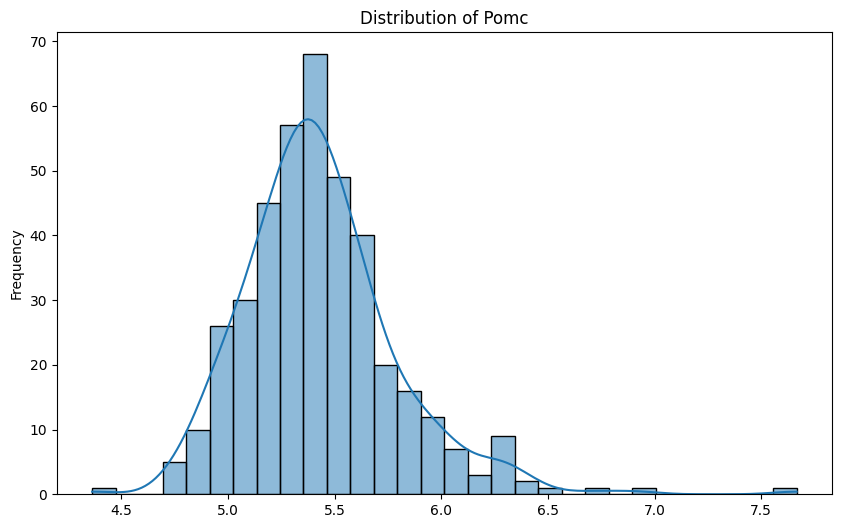

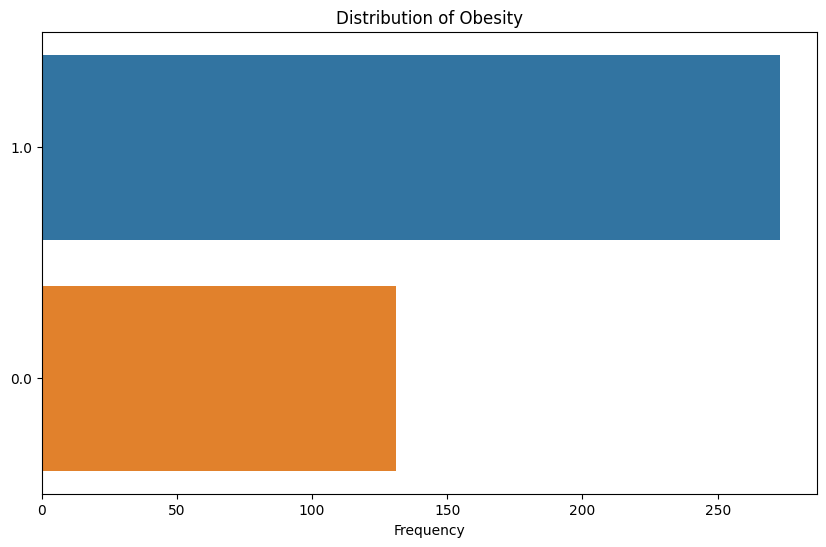

In [ ]:
condition_feature_cols = condition_merged_data.columns.tolist()[:-1]
gene_list = [gene_regressors_for_condition[0]] # Only show one gene
import seaborn as sns
import matplotlib.pyplot as plt

def plot_numeric_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column.capitalize()}')
    plt.xlabel('')
    plt.ylabel('Frequency')
    plt.show()

def plot_categorical_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.countplot(y=column, data=df, order=df[column].value_counts().index)
    plt.title(f'Distribution of {column.capitalize()}')
    plt.xlabel('Frequency')
    plt.ylabel('')
    plt.show()

def analyze_distributions(df, numerical_columns, categorical_columns):
    for col in numerical_columns:
        plot_numeric_distribution(df, col)

    for col in categorical_columns:
        plot_categorical_distribution(df, col)

# Sample usage:
analyze_distributions(condition_merged_data, numerical_columns=[ *gene_list], categorical_columns=[condition])

###Do Regression Over Gene Data for Condition

In [ ]:
import pandas as pd
import numpy as np
from sparse_lmm import VariableSelection

def preprocess_data(X_train, X_test=None):
    # Normalize training data
    mean_train = np.mean(X_train, axis=0)
    std_train = np.std(X_train, axis=0)

    X_train_normalized = (X_train - mean_train) / std_train

    # Set columns with zero std to zero for training data
    zero_std_columns_train = np.where(std_train == 0)[0]
    X_train_normalized[:, zero_std_columns_train] = 0

    if X_test is not None:
        # Normalize test data using training data's mean and std
        X_test_normalized = (X_test - mean_train) / std_train
        X_test_normalized[:, zero_std_columns_train] = 0
    else:
        X_test_normalized = None

    return X_train_normalized, X_test_normalized


In [ ]:
from sklearn.linear_model import LogisticRegression

def cross_validation(X, y, k=5):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    fold_size = len(X) // k
    accuracies = []

    for i in range(k):
        # Split data into train and test based on the current fold
        test_indices = indices[i*fold_size : (i+1)*fold_size]
        train_indices = np.setdiff1d(indices, test_indices)

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # Preprocess the train and test data
        X_train, X_test = preprocess_data(X_train, X_test)

        # Instantiate LogisticRegression with L1 regularization
        model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

        # Fit the logistic regression model on the training data
        model.fit(X_train, y_train)

        # Predict on the test data
        binary_predictions = model.predict(X_test)

        # Calculate accuracy for this fold
        accuracy = np.mean(binary_predictions == y_test)
        accuracies.append(accuracy)

    return np.mean(accuracies)

data_array_condition = condition_merged_data[gene_regressors_for_condition].values

# Normalize data
X_condition = data_array_condition
# print(X_condition.shape)

y_condition = condition_merged_data[condition].values
# print(y_condition.shape)
print(cross_validation(X_condition, y_condition))


0.6775


In [57]:
# Select relevant columns and convert to numpy array
print("Common gene regressors for condition and trait", gene_regressors_for_condition)
data_array_condition = condition_merged_data[gene_regressors_for_condition].values


# Normalize data
X_condition = data_array_condition
X_condition, _ = preprocess_data(X_condition)

y_condition = condition_merged_data[condition].values
model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
model.fit(X_condition, y_condition)
# Implementing k-fold cross-validation

Common gene regressors for condition and trait ['pomc', 'adcy3']


LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

##Condition Prediction

In [ ]:
# Select relevant columns and convert to numpy array
data_array_common_regressors = trait_merged_data[gene_regressors_for_condition].values.astype(float)
# print(data_array_common_regressors)

X_common_regressors = data_array_common_regressors
X_common_regressors, _ = preprocess_data(X_common_regressors)

predictions_condition = model.predict_proba(X_common_regressors)[:, 1]

(10, 8038)
(10,)
The shape of predicted condition is correct


#The Second Stage Regression Analysis

In [ ]:
#Add the predicted condition to the gene data for trait
trait_merged_data.insert(0, condition, predictions_condition)
trait_merged_data = trait_merged_data.drop(columns=gene_regressors_for_condition)
trait_merged_data

,Obesity,cdc42ep4,rgd1306682,naca,armc8,tnpo2,dixdc1,copb1,atp6v1h,mtfmt,...,csn1s1,sesn1,srsf7,loc362795,med8,dcaf8,prdm4,zfp212,setdb1,Epilepsy
GSM7177374,0.676401,9.618717,9.891297,12.300565,6.419549,12.669386,10.059711,9.799312,11.537340,9.030334,...,6.914544,7.092060,11.189447,5.304775,8.510160,6.569852,5.853281,8.957126,6.294718,0.0
GSM7177375,0.712198,8.433863,8.778094,11.692756,3.914837,12.223194,8.888625,8.817946,11.016124,7.773567,...,4.811550,5.153667,10.612376,2.772142,6.968354,3.985892,3.941980,7.321628,2.991078,0.0
GSM7177376,0.678236,9.538087,10.309369,12.274402,6.681351,12.660629,10.065700,9.892569,11.592283,9.041031,...,7.110058,6.917058,10.932825,6.182122,8.679627,6.425857,6.431147,9.182921,6.270126,0.0
GSM7177377,0.677586,9.543251,10.504767,12.164944,6.771357,12.895776,10.251254,9.950316,11.608143,9.053718,...,7.464339,7.051771,11.286278,6.126542,8.943465,6.561163,6.009738,9.249625,6.460323,0.0
GSM7177378,0.682241,10.020039,10.127184,12.390719,6.818306,12.932032,10.083568,9.931398,11.364371,9.258897,...,7.488847,7.192097,11.084257,6.668186,8.934796,6.595550,6.591733,9.202847,6.452069,0.0
GSM7177379,0.666437,9.719509,10.482978,12.426871,7.073187,12.815297,10.298792,10.162561,11.634647,9.370527,...,5.281077,7.654190,11.083828,7.071562,8.878292,6.915146,6.181138,9.296213,6.866693,1.0
GSM7177380,0.643150,9.633360,10.689914,12.293867,6.651998,12.764904,10.318104,10.166268,11.912020,9.188787,...,5.672141,8.104233,11.007412,6.471502,8.796462,7.138924,6.369072,9.027945,7.285396,1.0
GSM7177381,0.649661,9.942926,10.721436,12.501291,7.199519,12.854589,10.656119,10.371856,12.017256,9.531203,...,6.177870,8.090580,11.068743,6.792501,9.294503,7.310038,6.677113,9.605019,7.369830,1.0
GSM7177382,0.680331,8.854783,10.318286,11.949930,6.110339,12.129087,9.847022,9.480552,11.130028,8.646181,...,4.943605,6.081780,10.529133,5.636592,8.190744,5.562462,4.859847,9.132074,5.708269,1.0
GSM7177383,0.667428,9.871650,10.250974,12.204927,6.252654,12.508982,10.285210,9.728507,11.226546,8.909253,...,6.415080,7.176658,10.570252,5.500868,8.500556,6.771053,6.465117,9.082804,6.671698,1.0


##  Preliminary Analysis

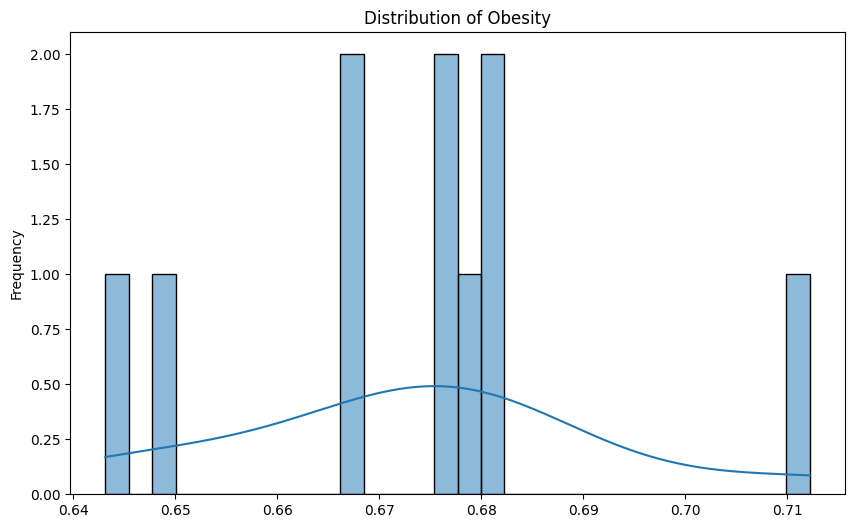

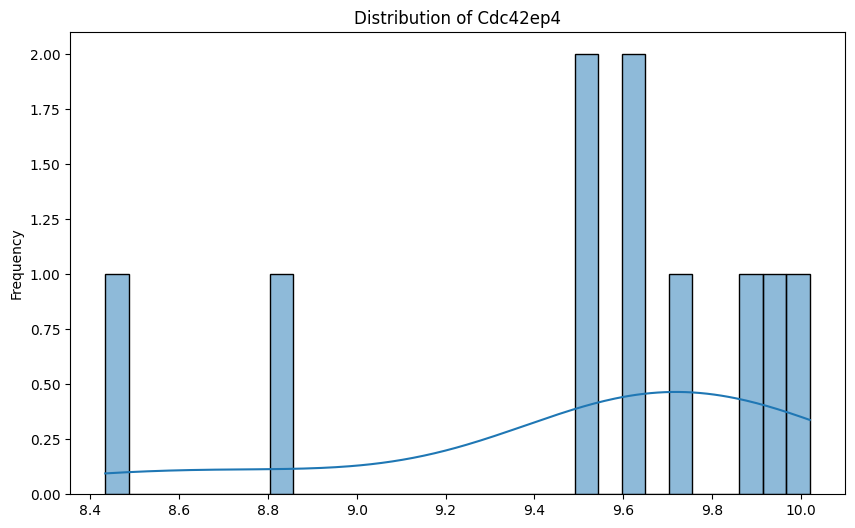

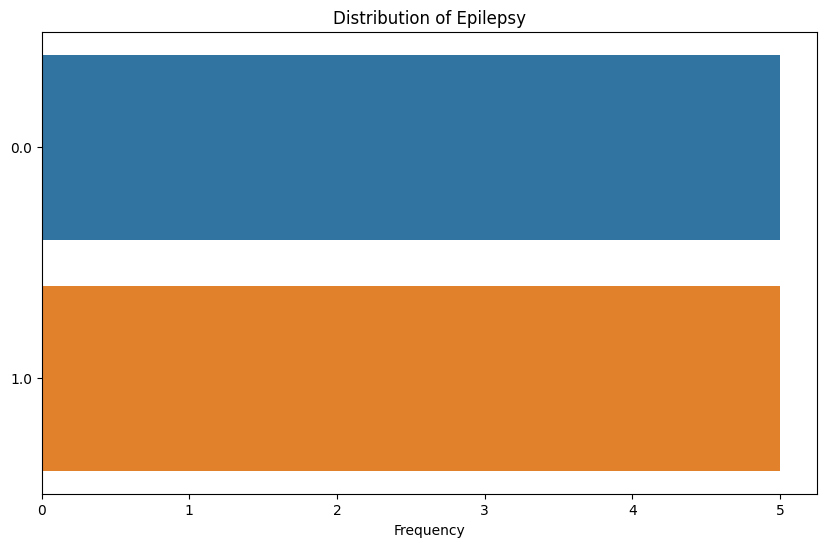

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
trait_feature_cols = trait_merged_data.columns.tolist()[:-1]
gene_list = [trait_feature_cols[1]] # [col for col in input_cols if gene in col.lower()]

def plot_numeric_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column.capitalize()}')
    plt.xlabel('')
    plt.ylabel('Frequency')
    plt.show()

def plot_categorical_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.countplot(y=column, data=df, order=df[column].value_counts().index)
    plt.title(f'Distribution of {column.capitalize()}')
    plt.xlabel('Frequency')
    plt.ylabel('')
    plt.show()

def analyze_distributions(df, numerical_columns, categorical_columns):
    for col in numerical_columns:
        plot_numeric_distribution(df, col)

    for col in categorical_columns:
        plot_categorical_distribution(df, col)

# Sample usage:
analyze_distributions(trait_merged_data, numerical_columns=[condition,*gene_list], categorical_columns=[trait])

## Do Regression & Cross Validation Over Gene Data for Trait

In [ ]:
import pandas as pd
import numpy as np
from sparse_lmm import VariableSelection


# Implementing k-fold cross-validation
def cross_validation(X, y, k=5):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    fold_size = len(X) // k
    accuracies = []

    for i in range(k):
        # Split data into train and test based on the current fold
        test_indices = indices[i*fold_size : (i+1)*fold_size]
        train_indices = np.setdiff1d(indices, test_indices)

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # Preprocess the train and test data
        X_train, X_test = preprocess_data(X_train, X_test)

        # Use the precision_lasso package for regression
        var_select = VariableSelection()
        var_select.fit(X_train, y_train)
        predictions = var_select.predict(X_test)

        # Turn the predictions into binary values using a threshold of 0.5
        binary_predictions = (predictions > 0.5).astype(int)

        # Calculate accuracy for this fold
        accuracy = np.mean(binary_predictions == y_test)
        accuracies.append(accuracy)

    return np.mean(accuracies), np.std(accuracies)


# Select relevant columns and convert to numpy array
X_trait = trait_merged_data.drop(columns=[trait]).values
y_trait = trait_merged_data[trait].values
cv_mean, cv_std = cross_validation(X_trait, y_trait)
print(f'The cross-validation accuracy is {(cv_mean * 100):.2f}% ± {(cv_std * 100):.2f}%')

The cross-validation accuracy is 70.00% ± 24.49%


In [ ]:
trait_merged_data

,Obesity,cdc42ep4,rgd1306682,naca,armc8,tnpo2,dixdc1,copb1,atp6v1h,mtfmt,...,csn1s1,sesn1,srsf7,loc362795,med8,dcaf8,prdm4,zfp212,setdb1,Epilepsy
GSM7177374,0.676401,9.618717,9.891297,12.300565,6.419549,12.669386,10.059711,9.799312,11.537340,9.030334,...,6.914544,7.092060,11.189447,5.304775,8.510160,6.569852,5.853281,8.957126,6.294718,0.0
GSM7177375,0.712198,8.433863,8.778094,11.692756,3.914837,12.223194,8.888625,8.817946,11.016124,7.773567,...,4.811550,5.153667,10.612376,2.772142,6.968354,3.985892,3.941980,7.321628,2.991078,0.0
GSM7177376,0.678236,9.538087,10.309369,12.274402,6.681351,12.660629,10.065700,9.892569,11.592283,9.041031,...,7.110058,6.917058,10.932825,6.182122,8.679627,6.425857,6.431147,9.182921,6.270126,0.0
GSM7177377,0.677586,9.543251,10.504767,12.164944,6.771357,12.895776,10.251254,9.950316,11.608143,9.053718,...,7.464339,7.051771,11.286278,6.126542,8.943465,6.561163,6.009738,9.249625,6.460323,0.0
GSM7177378,0.682241,10.020039,10.127184,12.390719,6.818306,12.932032,10.083568,9.931398,11.364371,9.258897,...,7.488847,7.192097,11.084257,6.668186,8.934796,6.595550,6.591733,9.202847,6.452069,0.0
GSM7177379,0.666437,9.719509,10.482978,12.426871,7.073187,12.815297,10.298792,10.162561,11.634647,9.370527,...,5.281077,7.654190,11.083828,7.071562,8.878292,6.915146,6.181138,9.296213,6.866693,1.0
GSM7177380,0.643150,9.633360,10.689914,12.293867,6.651998,12.764904,10.318104,10.166268,11.912020,9.188787,...,5.672141,8.104233,11.007412,6.471502,8.796462,7.138924,6.369072,9.027945,7.285396,1.0
GSM7177381,0.649661,9.942926,10.721436,12.501291,7.199519,12.854589,10.656119,10.371856,12.017256,9.531203,...,6.177870,8.090580,11.068743,6.792501,9.294503,7.310038,6.677113,9.605019,7.369830,1.0
GSM7177382,0.680331,8.854783,10.318286,11.949930,6.110339,12.129087,9.847022,9.480552,11.130028,8.646181,...,4.943605,6.081780,10.529133,5.636592,8.190744,5.562462,4.859847,9.132074,5.708269,1.0
GSM7177383,0.667428,9.871650,10.250974,12.204927,6.252654,12.508982,10.285210,9.728507,11.226546,8.909253,...,6.415080,7.176658,10.570252,5.500868,8.500556,6.771053,6.465117,9.082804,6.671698,1.0


In [ ]:
# Conduct regression on the whole dataset
# Instantiate the VariableSelection class
var_select = VariableSelection()

#X_trait = trait_merged_data.values
X_trait = trait_merged_data.drop(columns=[trait]).values
y_trait = trait_merged_data[trait].values
X_trait, _ = preprocess_data(X_trait)

# Fit the model
var_select.fit(X_trait, y_trait)

# Retrieve the coefficients
coefficients = var_select.getBeta().reshape(-1).tolist()
nlog_p_values = var_select.getNegLogP().reshape(-1).tolist()
p_values = [np.exp(-p) for p in nlog_p_values]

## Discussion

In [ ]:
import pandas as pd
from statsmodels.stats.multitest import multipletests


# Create a DataFrame for the regression results
regression_df = pd.DataFrame({
    'Variable': trait_feature_cols,
    'Coefficient': coefficients,
    'p_value': p_values
})

# Extract information about the lifestyle condition's effect
condition_effect = regression_df.iloc[0]

# Report the effect of the lifestyle condition
print(f"Effect of the condition on the target variable:")
print(f"Variable: {condition}")
print(f"Coefficient: {condition_effect['Coefficient']:.4f}")
print(f"p-value: {condition_effect['p_value']:.4g}\n")

Effect of the condition on the target variable:
Variable: Obesity
Coefficient: -0.4446
p-value: 0.1694



In [ ]:
threshold = 0.4

# Apply the Benjamini-Hochberg correction
rejected, corrected_p_values, _, _ = multipletests(regression_df['p_value'][1:], alpha=threshold, method='fdr_bh')

# Add the corrected p-values to the DataFrame (ignoring the first row which is the condition)
regression_df.loc[1:, 'corrected_p_value'] = corrected_p_values

# Now filter based on the corrected p-values
significant_genes = regression_df.loc[(regression_df.index > 0) & (regression_df['corrected_p_value'] < threshold)]
significant_genes_sorted = significant_genes.sort_values('corrected_p_value')

# Print and/or save your results as before
print(f"Genes with corrected p-value < {threshold}, affecting the trait {trait} conditional on the factor {condition}, sorted by corrected p-value:")
print(significant_genes_sorted[['Variable', 'Coefficient', 'corrected_p_value']].to_string(index=False))
# Save this to a CSV file
significant_genes_sorted.to_csv('significant_genes_report_corrected.csv', index=False)

print(f"\nFound {len(significant_genes_sorted)} significant genes with corrected p-value < {threshold}")

Genes with corrected p-value < 0.4, affecting the trait Epilepsy conditional on the factor Obesity, sorted by corrected p-value:
 Variable  Coefficient  corrected_p_value
      hk1     0.699703           0.351506
  tmem158    -0.728880           0.351506
      sf4     0.757170           0.351506
    ftsj1     0.633574           0.351506
    zfp93    -0.579789           0.351506
   csn1s1    -0.473515           0.351506
loc685604    -0.521396           0.359237

Found 7 significant genes with corrected p-value < 0.4
